# Seasonal Effects on Larceny Rates in Asheville

In [2]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as datetime

_the warning is due to statsmodel_

In [3]:
import seaborn as sns

In [58]:
sns.set_style("darkgrid")
sns.set_context("poster")

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [50]:
# s is our raw series of observations
s = pd.read_pickle('lar_series.pkl')

In [51]:
s.describe()

count           27657
unique             21
top       LARCENYFMMV
freq            11460
Name: offense_short_description, dtype: object

In [52]:
s.head()

incident_dt
2008-12-15 11:00:00          LARCFEL
2009-09-18 00:00:00    LARCENYFMBLDG
2009-10-01 00:00:00    LARCENYFMBLDG
2007-01-12 04:30:00      LARCENYFMMV
2012-07-26 00:00:00    LARCENYFMBLDG
Name: offense_short_description, dtype: object

In [53]:
X = s.resample('M').count()

In [54]:
X.sort_index(inplace=True)

In [55]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

In [56]:
print("dates run from {} to {}".format(X.index[0].date(), X.index[-1].date()))

dates run from 2005-01-31 to 2018-05-31


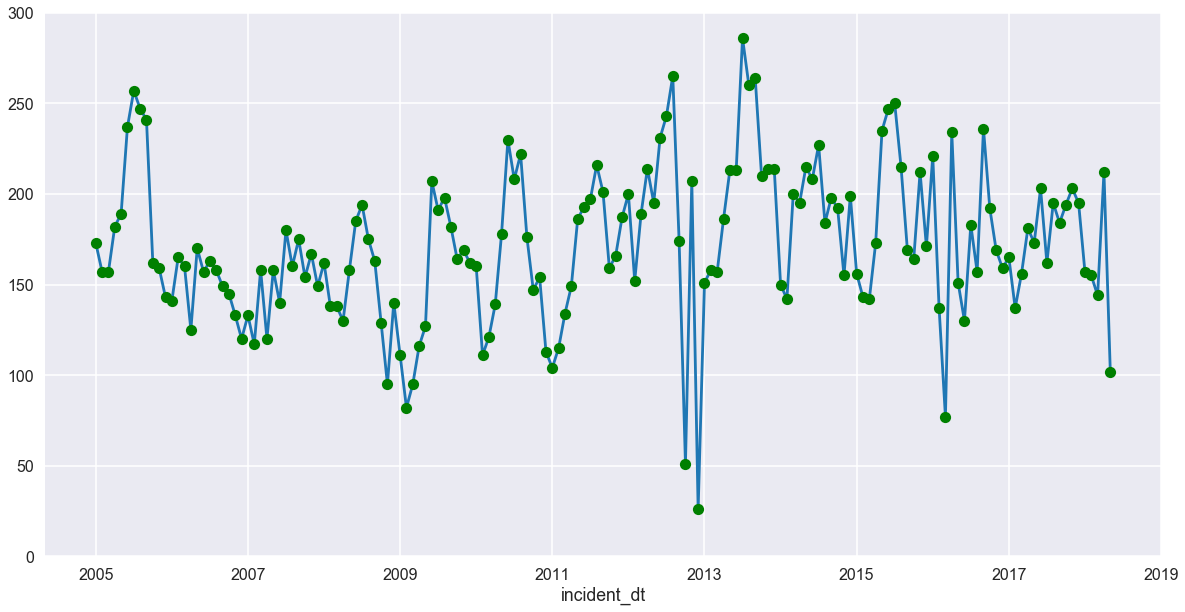

In [59]:
plt.ylim(0, 300)
X.plot()
X.plot(style='go', grid=True)

_remove outliers_

In [14]:
m = X.mean()
sd = X.std()

In [15]:
cut = 3 # number of sd to cut at

In [16]:
X2 = pd.Series(X).where(lambda x : x > m - cut * sd).fillna(method='bfill')

In [17]:
X2 = pd.Series(X2).where(lambda x : x < m + cut * sd).fillna(method='bfill')

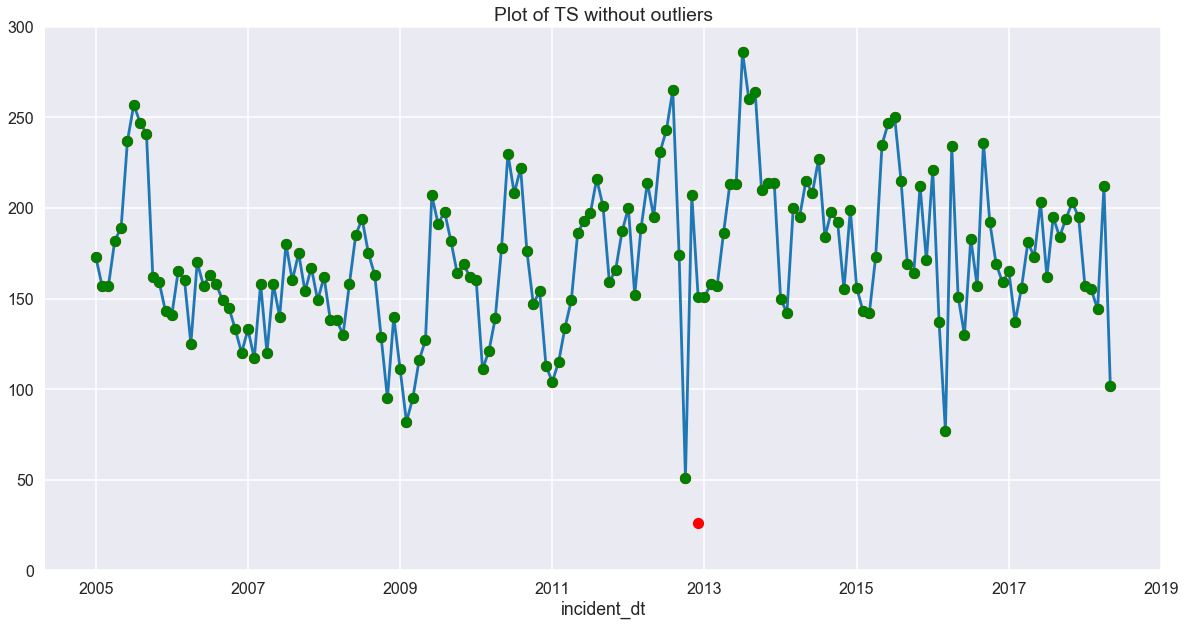

In [60]:
plt.ylim(0, 300)
X2.plot(title='Plot of TS without outliers')
X.plot(style='ro')
X2.plot(style='go', grid=True)

In [19]:
s_model = seasonal_decompose(X, model='additive')

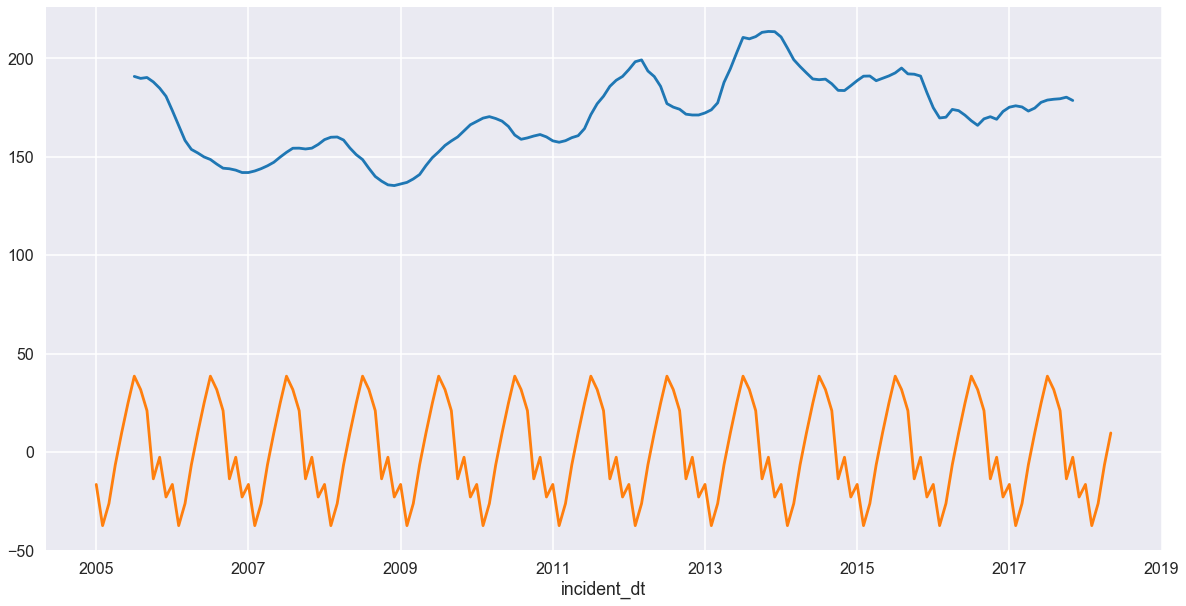

In [61]:
s_model.trend.plot(grid=True)
s_model.seasonal.plot(grid=True)

In [21]:
# s_model.trend.plot(grid=True)

In [22]:
# s_model.seasonal.plot()

In [23]:
s_high = s_model.seasonal.sort_values(ascending=False).head(5).mean()
s_low = s_model.seasonal.sort_values(ascending=True).head(5).mean()
print("seasonal effect is from {} to {}".format(s_low, s_high))

seasonal effect is from -37.372061965811966 to 38.49225427350428


In [24]:
res = s_model.seasonal.to_frame()
res.columns = ['seasonal']
res['trend'] = s_model.trend
res['pred'] = res['trend'] + res['seasonal']
res['actual'] = X2

In [25]:
# res.head(20)

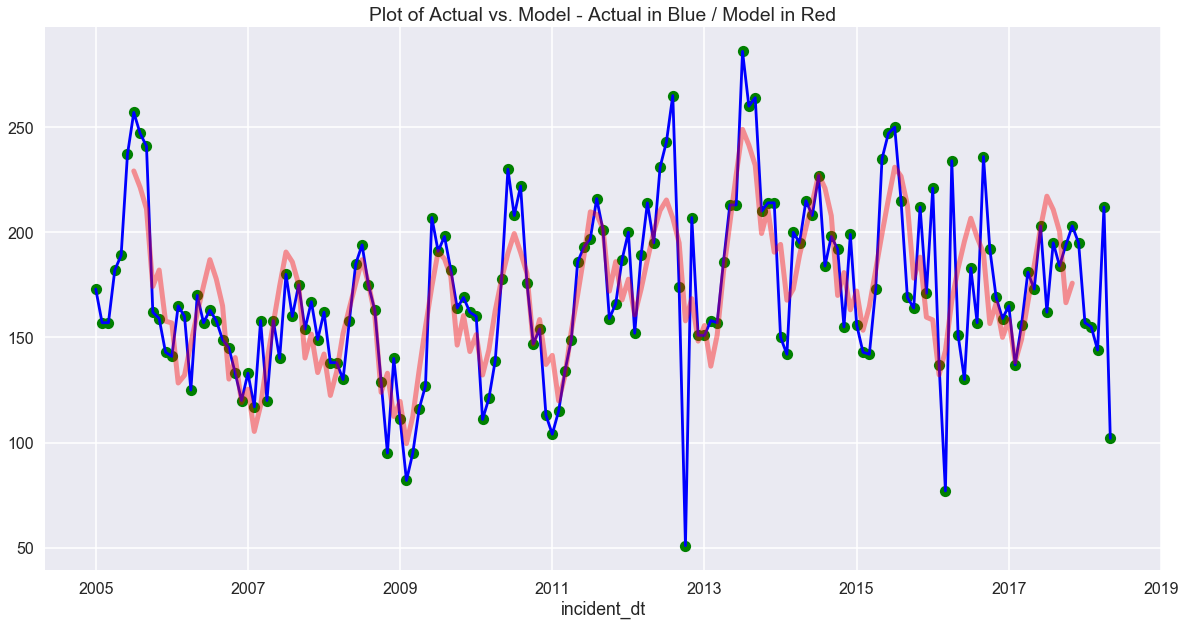

In [63]:
res['actual'].plot(style='go', sharex=True)
res['actual'].plot(color='blue', sharex=True)
#res['pred'].plot(style='ko')
res['pred'].plot(color='red', lw=5.0, sharex=True, alpha=0.4,
                 title='Plot of Actual vs. Model - Actual in Blue / Model in Red')

In [27]:
year_07 = res['2007':'2010']

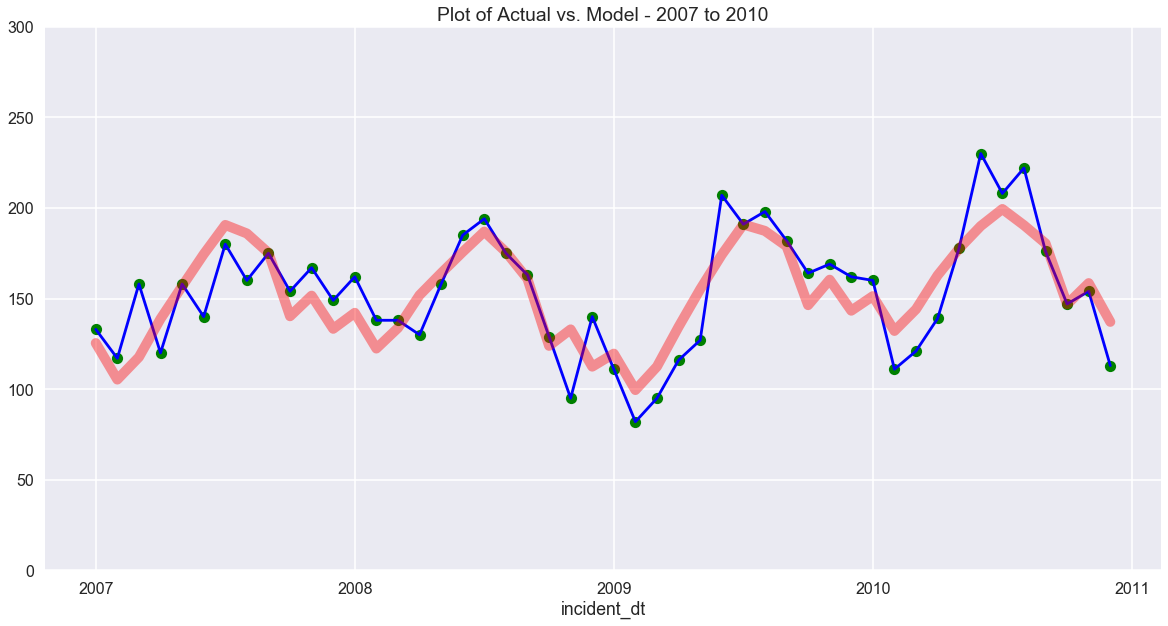

In [64]:
plt.ylim(0, 300)
year_07['actual'].plot(style='go', sharex=True)
year_07['actual'].plot(color='blue', sharex=True)
#year_07['pred'].plot(style='ko')
year_07['pred'].plot(color='red', lw=10.0, sharex=True, alpha=0.4,
                 title='Plot of Actual vs. Model - 2007 to 2010', grid=True)

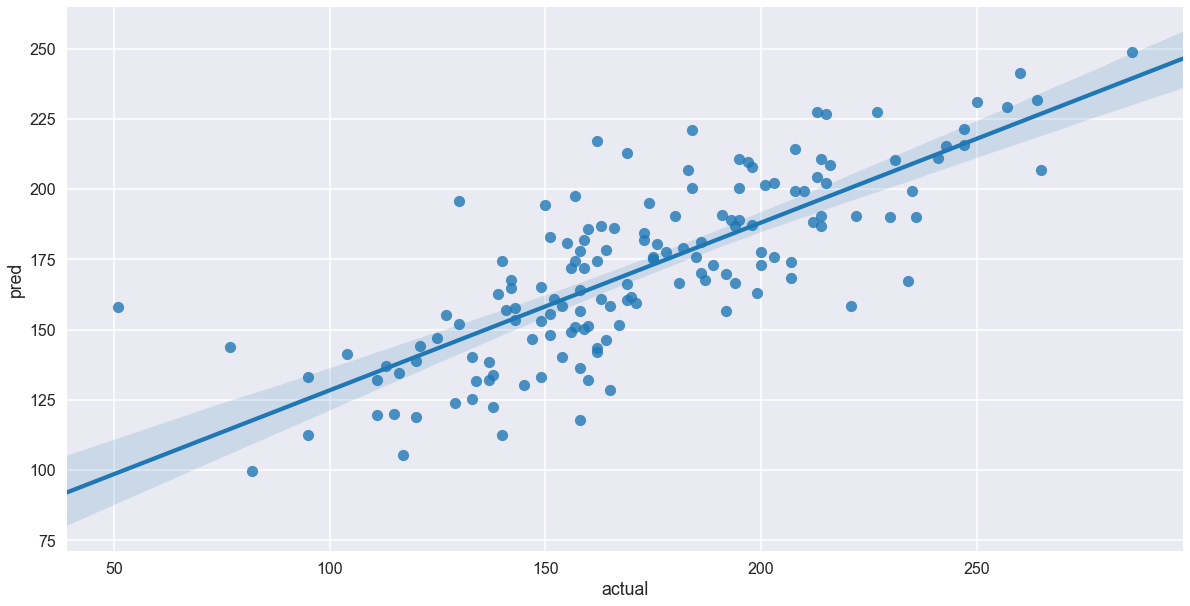

In [65]:
sns.regplot(x='actual', y='pred', data=res)

In [66]:
res_no_na = res.dropna()

In [67]:
model = sm.OLS(res_no_na['actual'], res_no_na['pred'])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     7167.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):          2.94e-127
Time:                        14:57:21   Log-Likelihood:                -692.40
No. Observations:                 149   AIC:                             1387.
Df Residuals:                     148   BIC:                             1390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred           1.0061      0.012     84.657      0.0

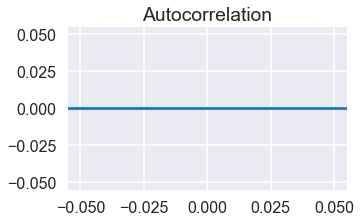

In [68]:
plt.rcParams['figure.figsize'] = (5.0, 3.0)
fig = plot_acf(res['trend'])

In [69]:
post_bc = X2[datetime.datetime(2013, 9, 1):]
pre_bc = X2[:datetime.datetime(2013, 9, 1):]

In [70]:
print(len(post_bc))
print(len(pre_bc))

57
104


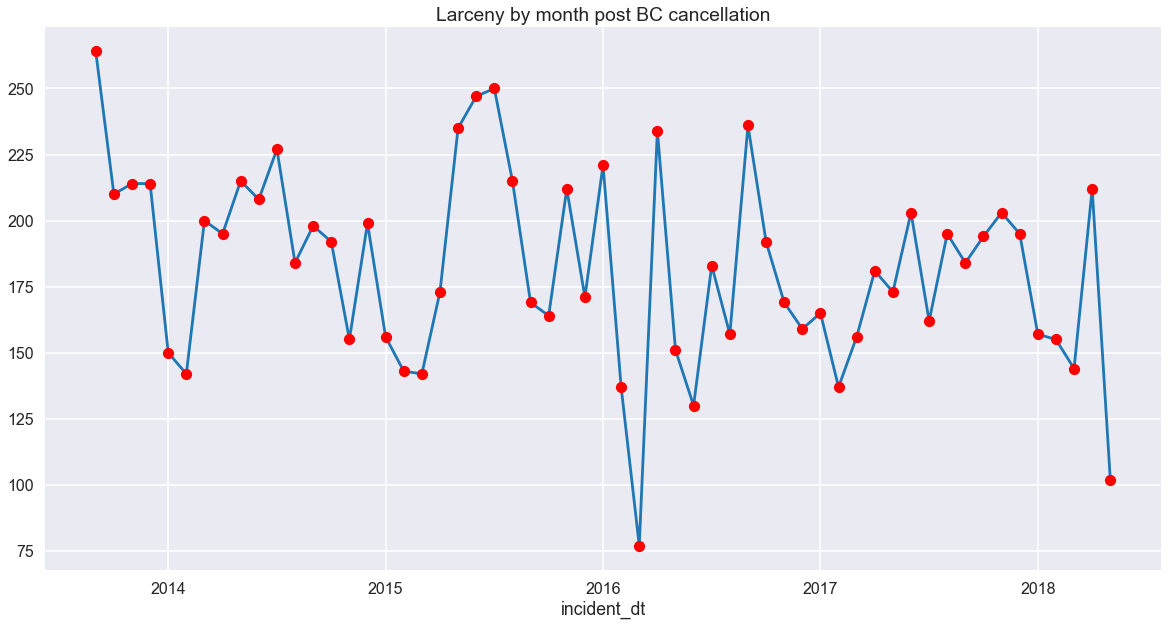

In [71]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
post_bc.plot()
post_bc.plot(style='ro', grid=True, title='Larceny by month post BC cancellation')

In [72]:
s_post_bc = seasonal_decompose(post_bc)

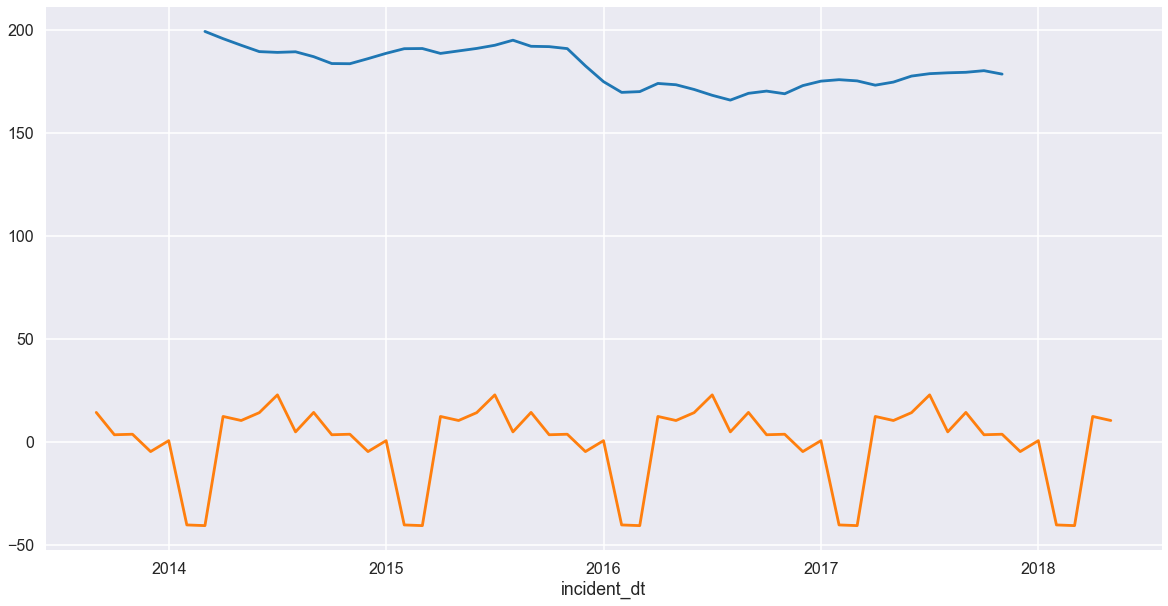

In [73]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
s_post_bc.trend.plot(grid=True)
s_post_bc.seasonal.plot(grid=True)

In [74]:
# s_post_bc.seasonal.plot(grid=True)

In [75]:
post_bc_s_high = s_post_bc.seasonal.sort_values(ascending=False).head(5).mean()
post_bc_s_low = s_post_bc.seasonal.sort_values(ascending=True).head(5).mean()
print("post BC seasonal effect is from {} to {}".format(post_bc_s_low, post_bc_s_high))

post BC seasonal effect is from -40.7349537037037 to 21.031712962962953


In [76]:
s_post_bc.seasonal.max()-s_post_bc.seasonal.min()

63.468749999999986

In [77]:
res2 = s_post_bc.seasonal.to_frame()
res2.columns = ['seasonal']
res2['trend'] = s_post_bc.trend
res2['pred'] = res2['trend'] + res2['seasonal']
res2['actual'] = post_bc

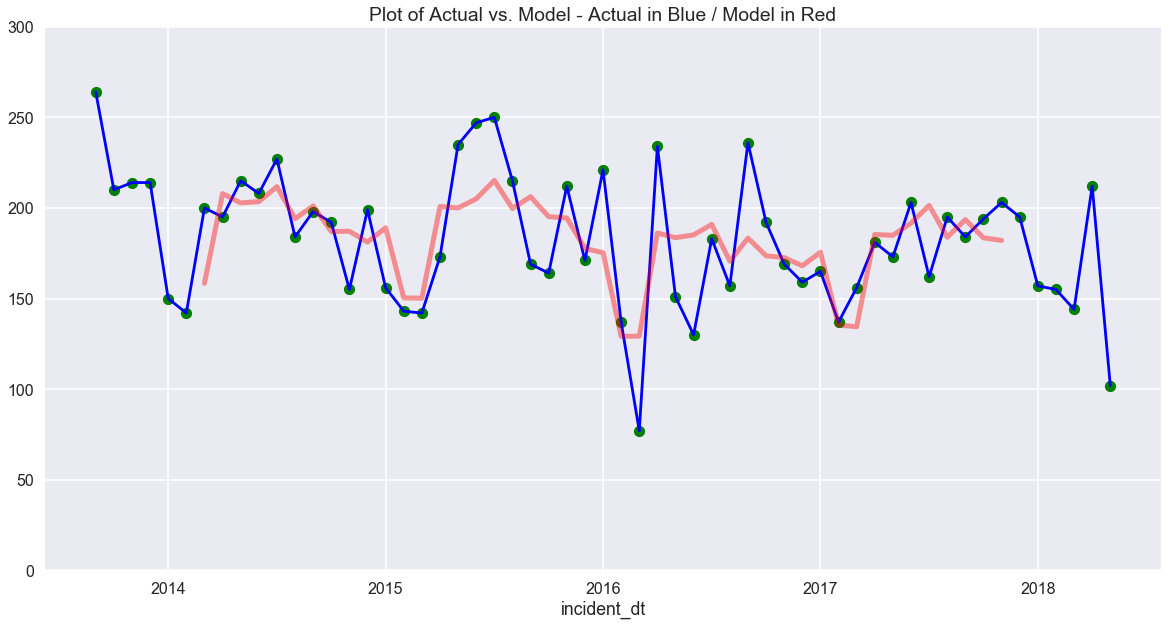

In [79]:
plt.ylim(0, 300)
res2['actual'].plot(style='go', sharex=True)
res2['actual'].plot(color='blue', sharex=True)
#res['pred'].plot(style='ko')
res2['pred'].plot(color='red', lw=5.0, sharex=True, alpha=0.4,
                 title='Plot of Actual vs. Model - Actual in Blue / Model in Red', grid=True)

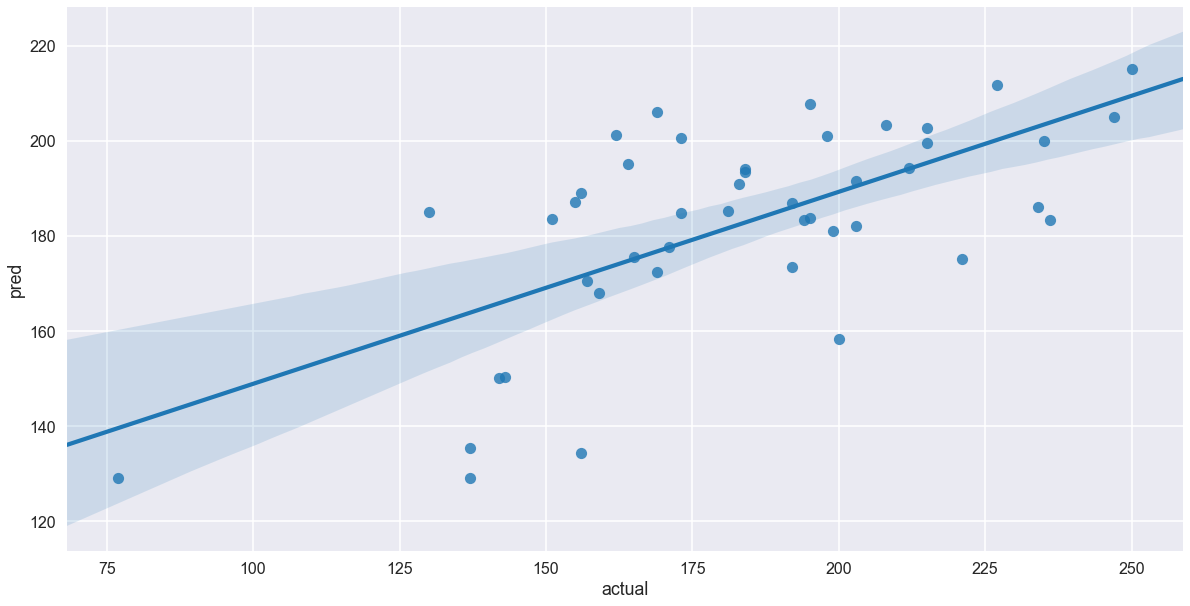

In [80]:
sns.regplot(x='actual', y='pred', data=res2)

In [81]:
post_bc_res_no_na = res2.dropna()

In [82]:
model = sm.OLS(post_bc_res_no_na['actual'], post_bc_res_no_na['pred'])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2195.
Date:                Tue, 26 Jun 2018   Prob (F-statistic):           3.46e-39
Time:                        14:57:42   Log-Likelihood:                -210.73
No. Observations:                  45   AIC:                             423.5
Df Residuals:                      44   BIC:                             425.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred           1.0045      0.021     46.846      0.0

In [83]:
s_pre_bc = seasonal_decompose(pre_bc)

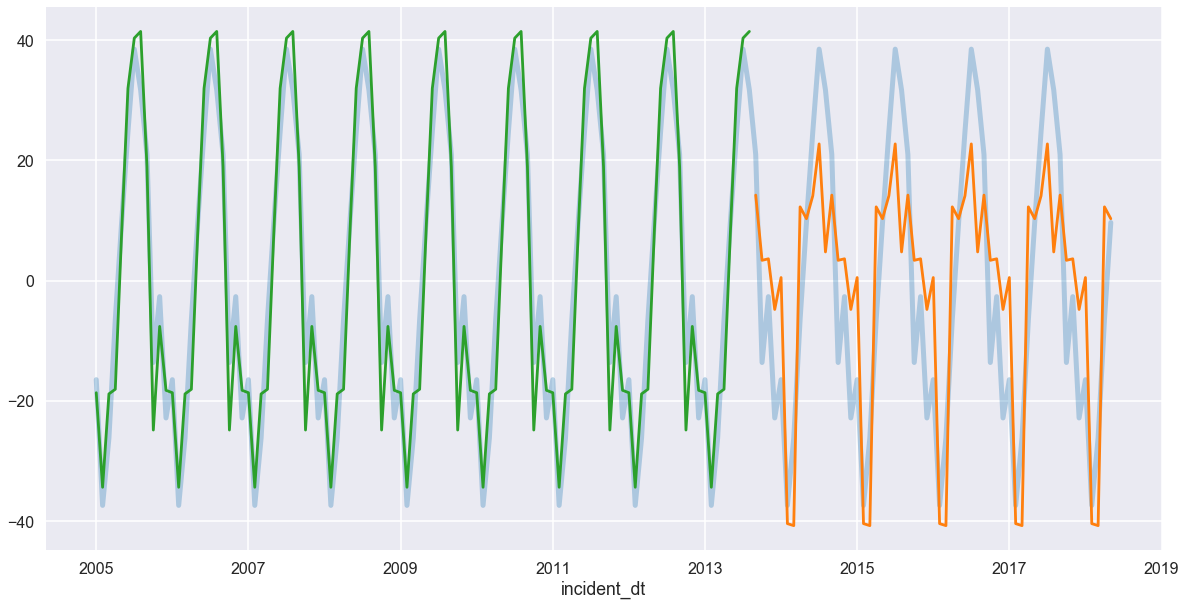

In [85]:
s_model.seasonal.plot(lw=5.0, alpha=0.3)
s_post_bc.seasonal.plot()
s_pre_bc.seasonal.plot()